In [41]:
# Import necessary libraries and configure matplotlib parameters
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import pandas as pd 
import numpy as np
import seaborn as sns
import math
import time
import tqdm
import gc
from numba import njit, prange
from joblib import Parallel, delayed
from scipy import stats
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import NullLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
from brokenaxes import brokenaxes
from pathlib import Path

mpl.rcdefaults()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.8
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.xmargin'] = 0.05
plt.rcParams['axes.grid']='True'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['xtick.minor.visible'] ='True'
plt.rcParams['ytick.minor.visible'] ='True'
plt.rcParams['xtick.major.size'] =10
plt.rcParams['xtick.minor.size'] =5
plt.rcParams['xtick.major.width'] =2
plt.rcParams['xtick.minor.width'] =1
plt.rcParams['xtick.major.pad']=8
plt.rcParams['ytick.major.size'] =10
plt.rcParams['ytick.minor.size'] =5
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.minor.width'] =1
plt.rcParams['ytick.major.pad']=8
plt.rcParams['figure.subplot.wspace']=0.25
plt.rcParams['figure.subplot.hspace']=0.5
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.8
plt.rcParams['savefig.bbox']='tight'
plt.rcParams['savefig.format']='pdf'
rc_dict = mpl.rcParams.copy()

In [3]:
# Read burst table
def Xreaddata(path, col_indices, new_col_names, startrow=0):
    if len(col_indices) != len(new_col_names):
        raise ValueError("The number of column indices must match the number of new column names.")
    df_0 = pd.read_csv(path, dtype=str)
    df = df_0.iloc[startrow:, col_indices]
    df.columns = new_col_names
    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except ValueError:
            pass
    df = df.fillna(np.nan)
    df = df.sort_values(by='t')
    df = df.reset_index(drop=True)
    return df_0, df
    
b_fast1=Xreaddata('Data\\20201124A\\Burst_Table\\FAST#1.csv',
            [0,2,6,4],['t','s','w','f'],
            startrow=0)

b_fast2=Xreaddata('Data\\20201124A\\Burst_Table\\FAST#2.csv',
            [2,5,4,7],['t','s','w','f'],
            startrow=2) 
b_fast2[1]['s']=b_fast2[1]['s']/1000

b_ugmrt=Xreaddata('Data\\20201124A\\Burst_Table\\uGMRT.csv',
            [1,4,2,5],['t','s','w','f'],
            startrow=0)  

b_effelsberg=Xreaddata('Data\\20201124A\\Burst_Table\\Effelsberg.csv',
            [1,5,3,7],['t','s','w','f'],
            startrow=0)  

In [5]:
#Further reduce the data table
def Xselectdata2(df_s, nummin, dnum, sep):
    t_bins = np.arange(np.floor(df_s['t'].min()) - (1 - sep), np.ceil(df_s['t'].max()) + (1 - sep) + dnum, dnum)
    num, _ = np.histogram(df_s['t'], t_bins)
    date_s = np.where(num >= nummin)[0]
    date_s = date_s * dnum
    df_list = []
    for date in date_s:
        mask = np.logical_and(df_s['t'] > (date + np.floor(df_s['t'].min()) - (1 - sep)), 
                              df_s['t'] < (date + np.floor(df_s['t'].min()) - (1 - sep)) + dnum)
        df_temp = df_s.loc[mask, :].reset_index(drop=True)
        df_temp.columns = [f'{col}' for col in df_temp.columns] 
        df_list.append(df_temp)
    return df_s, df_list
    
def burstverify_anyday(bi,nummin,dnum,sep) :
    bi_ss=Xselectdata2(bi[1],nummin=nummin,dnum=dnum,sep=sep)
    b_s=[]
    for i in range(len(bi_ss[1])):
        b_s.append(bi_ss[1][i]['t']*86400)
        bi_ss[1][i]['t_s']=b_s[i]   
        waitingtime=np.diff(b_s[i])
        bi_ss[1][i]['waitingtime']=np.concatenate(([np.inf],waitingtime))
    return bi_ss


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.78s/it]


Please find periodograms for all MJDs in "Periodograms" folder.


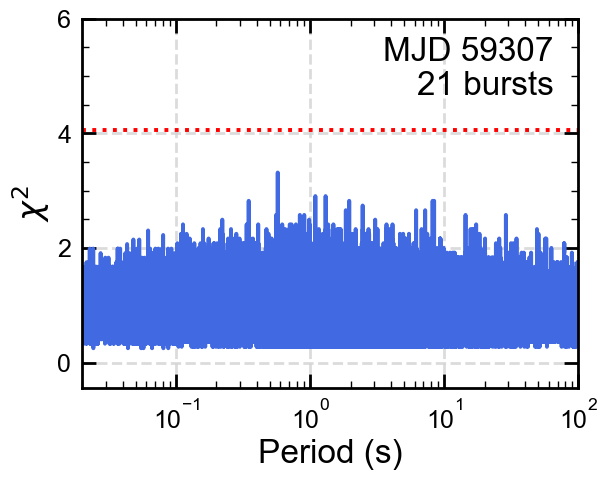

In [43]:
# Phase folding algorithm for periodicity analysis (numba)
@njit(parallel=True)
def phase_fold_and_calc_chi2(t, p_arr, bins_num=30):
    bursts_len= len(t)
    chi_arr = np.zeros(p_arr.shape[0], dtype=np.float64)
    q = 1.0 + (bins_num + 1) / (6.0 * bursts_len) # Williams' correction
    for i in prange(p_arr.shape[0]):
        p = p_arr[i]
        fold = np.mod(t / p, 1.0)
        O = np.zeros(bins_num, dtype=np.int64)
        for val in fold:
            if val < 1.0:
                bin_index = int(val * bins_num)
                if bin_index == bins_num:
                    bin_index = bins_num - 1
                O[bin_index] += 1
        E = len(t) / bins_num
        chi2 = np.sum((O - E)**2 / E) / (bins_num - 1)
        chi_arr[i] = chi2/q
    return chi_arr

# Segmented period search (when searching for periods > 0.1 s, exclude bursts with waiting times < 0.05 s)
def segmented_search(b_ss, day, bins_num):
    b_sss_0 = b_ss[1][day].loc[(b_ss[1][day]['waitingtime'] > 0)]
    p_arr_0 = np.linspace(0.01, 0.1, int((0.1-0.01)/1e-6)+1)
    chi2_arr_0 = phase_fold_and_calc_chi2(np.array(b_sss_0['t_s']), p_arr_0, bins_num)
    b_sss_1 = b_ss[1][day].loc[(b_ss[1][day]['waitingtime'] > 0.05)]
    p_arr_1 = np.linspace(0.1, 100, int((100-0.1)/1e-6)+1)
    chi2_arr_1 = phase_fold_and_calc_chi2(np.array(b_sss_1['t_s']), p_arr_1, bins_num)
    p_arr=np.concatenate((p_arr_0,p_arr_1))
    chi2_arr=np.concatenate((chi2_arr_0,chi2_arr_1))
    del p_arr_0, p_arr_1, chi2_arr_0, chi2_arr_1
    gc.collect()
    result = {
        'period_array': (p_arr),
        'chi2_array': (chi2_arr),
        'MJD': np.floor(min(b_sss_0['t'])),
        'N_burst':int(len(b_sss_0))
    }
    return result

gc.collect()
bins_num = 30
p_value = (1 - stats.norm.cdf(7))
threshold = stats.chi2.isf(p_value, bins_num-1)/(bins_num-1) 

# Plot periodograms (Extended Data Figure 1
# Here we only plot MJD 59307 as an example.
b_ss=burstverify_anyday(b_fast1, nummin=1,dnum=1,sep=0)
for i in tqdm.tqdm([0]):
    gc.collect()
    r=segmented_search(b_ss, i, bins_num = 30)
    fig, ax=plt.subplots()
    ax.plot(r['period_array'], r['chi2_array'], alpha=1, color='royalblue')
    ax.set_xscale('log')
    ax.axhline(threshold, color='red', linestyle='dotted')
    ax.text(0.95, 0.95, 'MJD %i' % r['MJD'], transform=ax.transAxes, fontsize=24,
             verticalalignment='top', horizontalalignment='right')
    ax.text(0.95, 0.86, '%i bursts' % r['N_burst'], transform=ax.transAxes, fontsize=24,
             verticalalignment='top', horizontalalignment='right')
    ax.set_xlim(0.02, 100)
    ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.set_ylim(-0.45,6)
    ax.set_xlabel('Period (s)',fontsize=24)
    ax.set_ylabel('$\\chi ^{2}$',fontsize=24)
    del r,fig
    gc.collect()
print('Please find periodograms for all MJDs in "Periodograms" folder.')

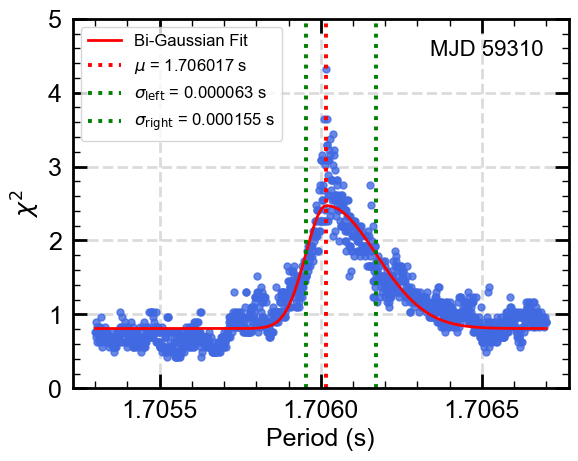

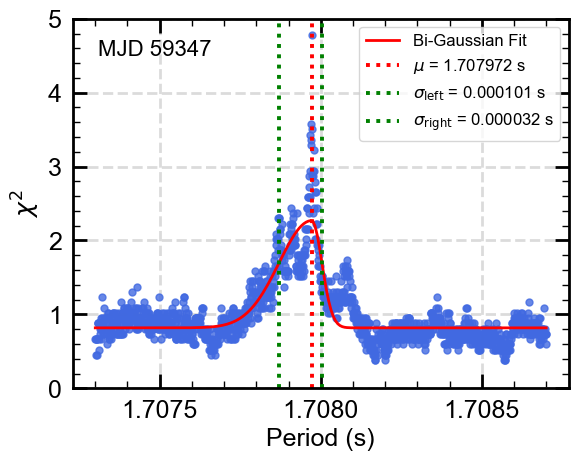

In [11]:
# Plot Extended Data Figure 2
def bi_gaussian(x, amplitude, mu, sigma_left, sigma_right,C):
    return amplitude * np.exp(-np.where(x <= mu, 
                                       (x - mu)**2/(2*sigma_left**2), 
                                       (x - mu)**2/(2*sigma_right**2)))+C

b_ss=burstverify_anyday(b_fast1, nummin=1,dnum=1,sep=0)
bins_num = 30

day=3 # MJD 59310
b_sss = b_ss[1][day].loc[(b_ss[1][day]['waitingtime']>0.05)]
p_s=1.7053
p_e=1.7067
p_res=1e-6
p_arr = np.linspace(p_s, p_e, int((p_e-p_s)/p_res)+1)
chi2_arr = phase_fold_and_calc_chi2(np.array(b_sss['t_s']), p_arr, bins_num)

x_data = p_arr
y_data = chi2_arr

amplitude_guess = 5
mu_fixed = 1.706017
sigma_left_guess = 0.0001
sigma_right_guess = 0.0001
C_guess = 1
initial_guesses = [amplitude_guess, mu_fixed, sigma_left_guess, sigma_right_guess, C_guess] 
lower_bounds = [0, mu_fixed,  0, 0, 0]
upper_bounds = [np.inf, mu_fixed+1e-7, np.inf, np.inf, np.inf]
bounds = (lower_bounds, upper_bounds)
params, cov = curve_fit(bi_gaussian, x_data, y_data,
                        p0=initial_guesses,bounds=bounds)
amplitude_fit, _, sigma_left_fit, sigma_right_fit, C_fit = params

fig=plt.figure()
plt.plot(x_data, y_data, 'o', color='royalblue', alpha=0.8,markersize=5)
x_fit = np.linspace(min(x_data), max(x_data), 200)
y_fit = bi_gaussian(x_fit, amplitude_fit, mu_fixed, sigma_left_fit,sigma_right_fit,C_fit)
plt.plot(x_fit, y_fit, '-', label='Bi-Gaussian Fit', color='red', linewidth=2)
plt.axvline(mu_fixed, color='r', linestyle=':',label='$\\mu$ = 1.706017 s')
plt.axvline(mu_fixed - sigma_left_fit, color='green', linestyle=':',label='$\\sigma_{\\mathrm{left}}$ = %.6f s'%sigma_left_fit)
plt.axvline(mu_fixed + sigma_right_fit, color='green', linestyle=':',label='$\\sigma_{\\mathrm{right}}$ = %.6f s'%sigma_right_fit)
ax=fig.get_axes()
plt.text(0.95,0.9,'MJD 59310',transform=ax[0].transAxes, fontsize=16,horizontalalignment='right')
plt.xlabel('Period (s)')
plt.ylabel('$\\chi^2$')
plt.ylim(0,5)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


day=35 # MJD 59347
b_sss = b_ss[1][day].loc[(b_ss[1][day]['waitingtime']>0.05)]
p_s=1.7073
p_e=1.7087
p_res=1e-6
p_arr = np.linspace(p_s, p_e, int((p_e-p_s)/p_res)+1)
chi2_arr = phase_fold_and_calc_chi2(np.array(b_sss['t_s']), p_arr, bins_num)

x_data = p_arr
y_data = chi2_arr

amplitude_guess = 5
mu_fixed = 1.707972
sigma_left_guess = 0.0001
sigma_right_guess = 0.0001
C_guess = 1
initial_guesses = [amplitude_guess, mu_fixed, sigma_left_guess, sigma_right_guess, C_guess] 
lower_bounds = [0, mu_fixed,  0, 0, 0]
upper_bounds = [np.inf, mu_fixed+1e-7, np.inf, np.inf, np.inf]
bounds = (lower_bounds, upper_bounds)
params, cov = curve_fit(bi_gaussian, x_data, y_data,
                        p0=initial_guesses,bounds=bounds)
amplitude_fit, _, sigma_left_fit, sigma_right_fit, C_fit = params

fig=plt.figure()
plt.plot(x_data, y_data, 'o', color='royalblue', alpha=0.8,markersize=5)
x_fit = np.linspace(min(x_data), max(x_data), 200)
y_fit = bi_gaussian(x_fit, amplitude_fit, mu_fixed, sigma_left_fit,sigma_right_fit,C_fit)
plt.plot(x_fit, y_fit, '-', label='Bi-Gaussian Fit', color='red', linewidth=2)
plt.axvline(mu_fixed, color='r', linestyle=':',label='$\\mu$ = 1.707972 s')
plt.axvline(mu_fixed - sigma_left_fit, color='green', linestyle=':',label='$\\sigma_{\\mathrm{left}}$ = %.6f s'%sigma_left_fit)
plt.axvline(mu_fixed + sigma_right_fit, color='green', linestyle=':',label='$\\sigma_{\\mathrm{right}}$ = %.6f s'%sigma_right_fit)
ax=fig.get_axes()
plt.text(0.05,0.9,'MJD 59347',transform=ax[0].transAxes, fontsize=16,horizontalalignment='left')
plt.xlabel('Period (s)')
plt.ylabel('$\\chi^2$')
plt.ylim(0,5)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

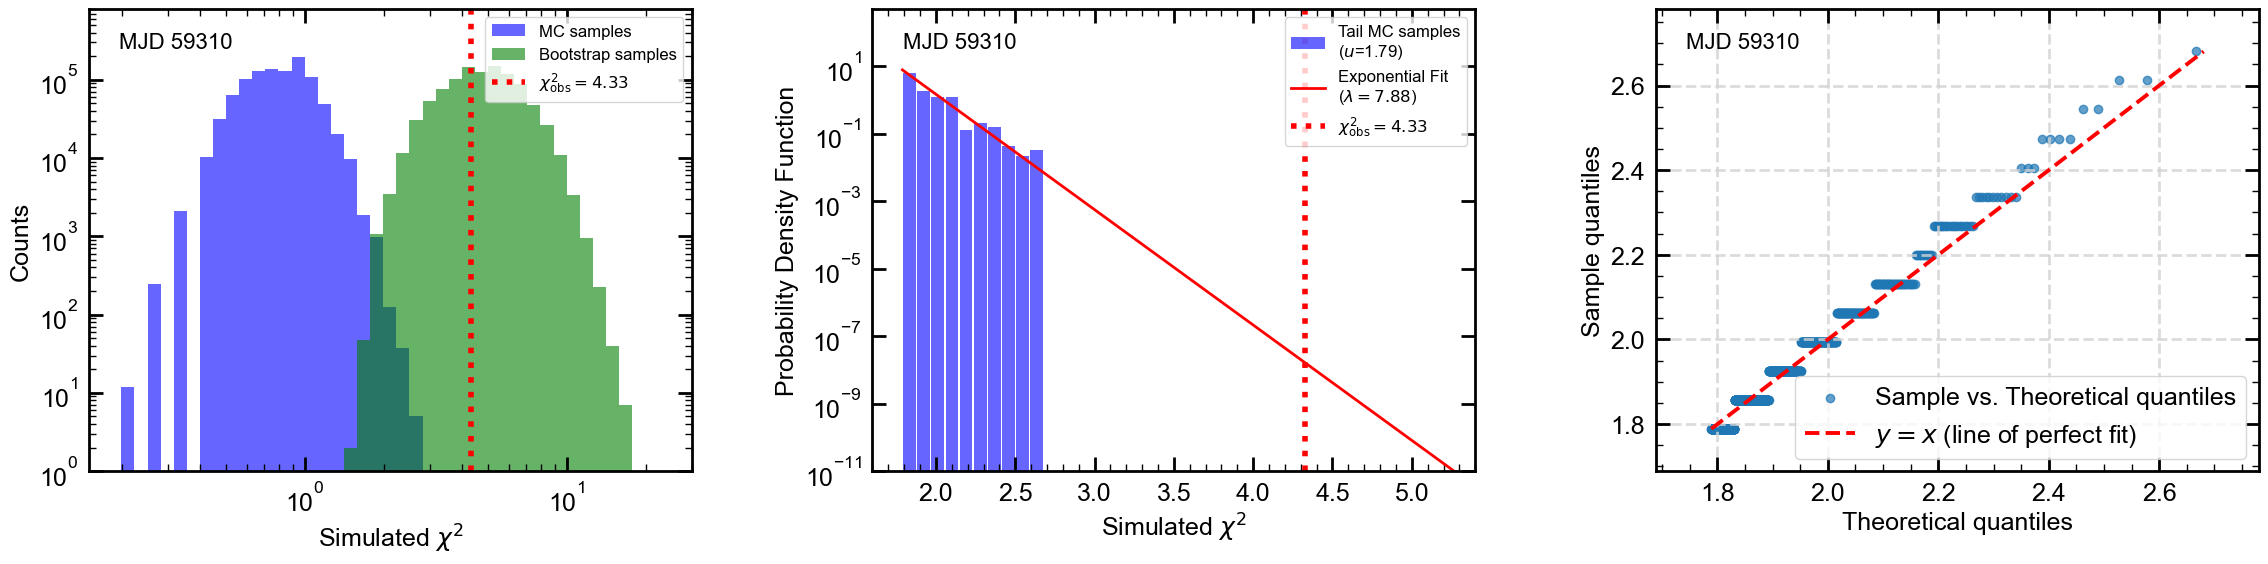

MJD 59310 chi2 p-value: 2.083545e-12
Corresponding Gaussian significance: 6.9



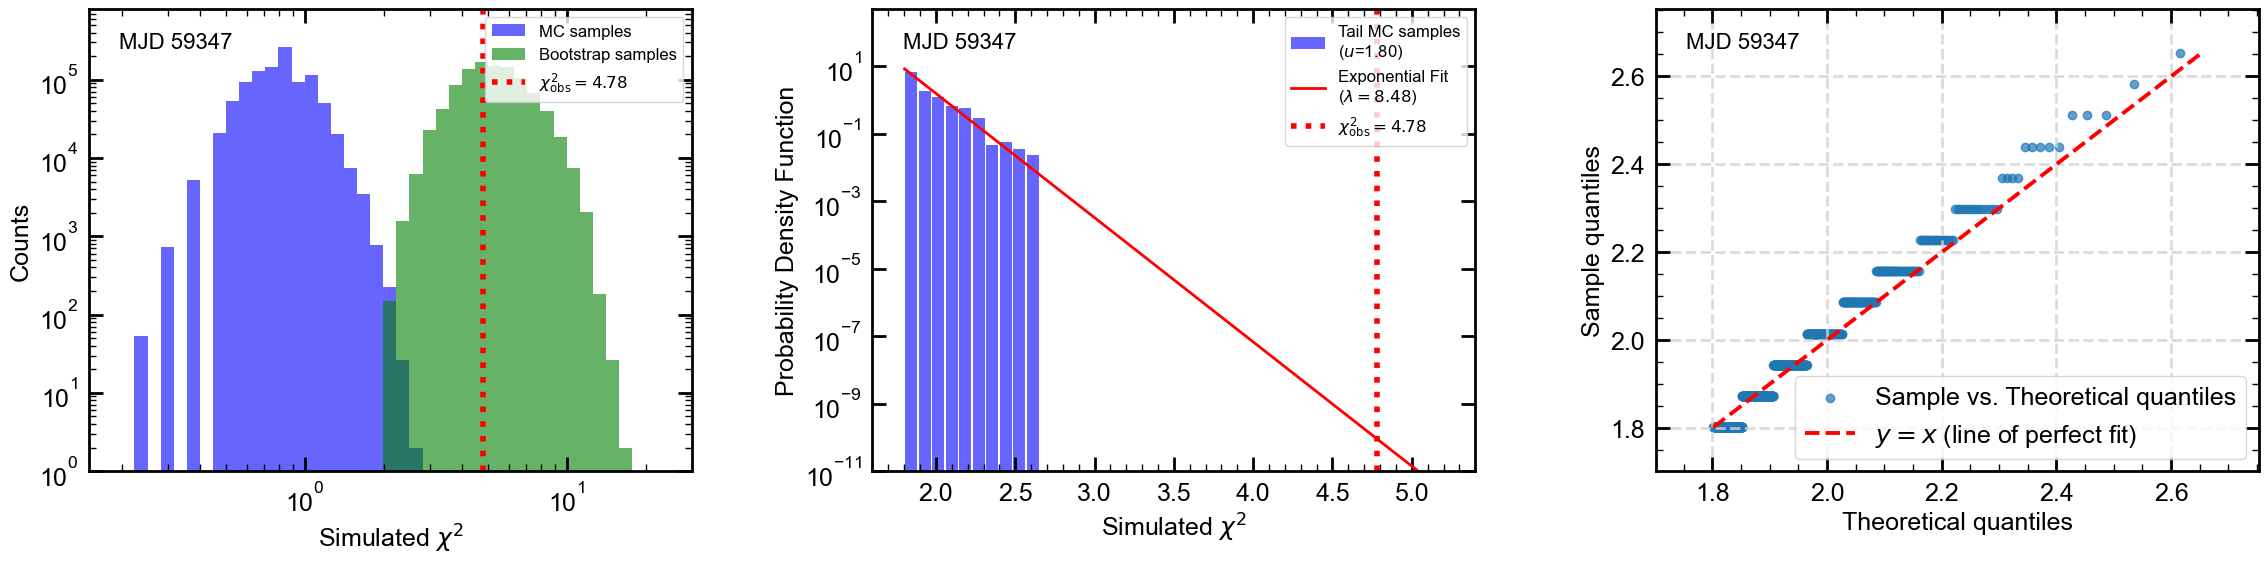

MJD 59347 chi2 p-value: 1.059374e-14
Corresponding Gaussian significance: 7.6



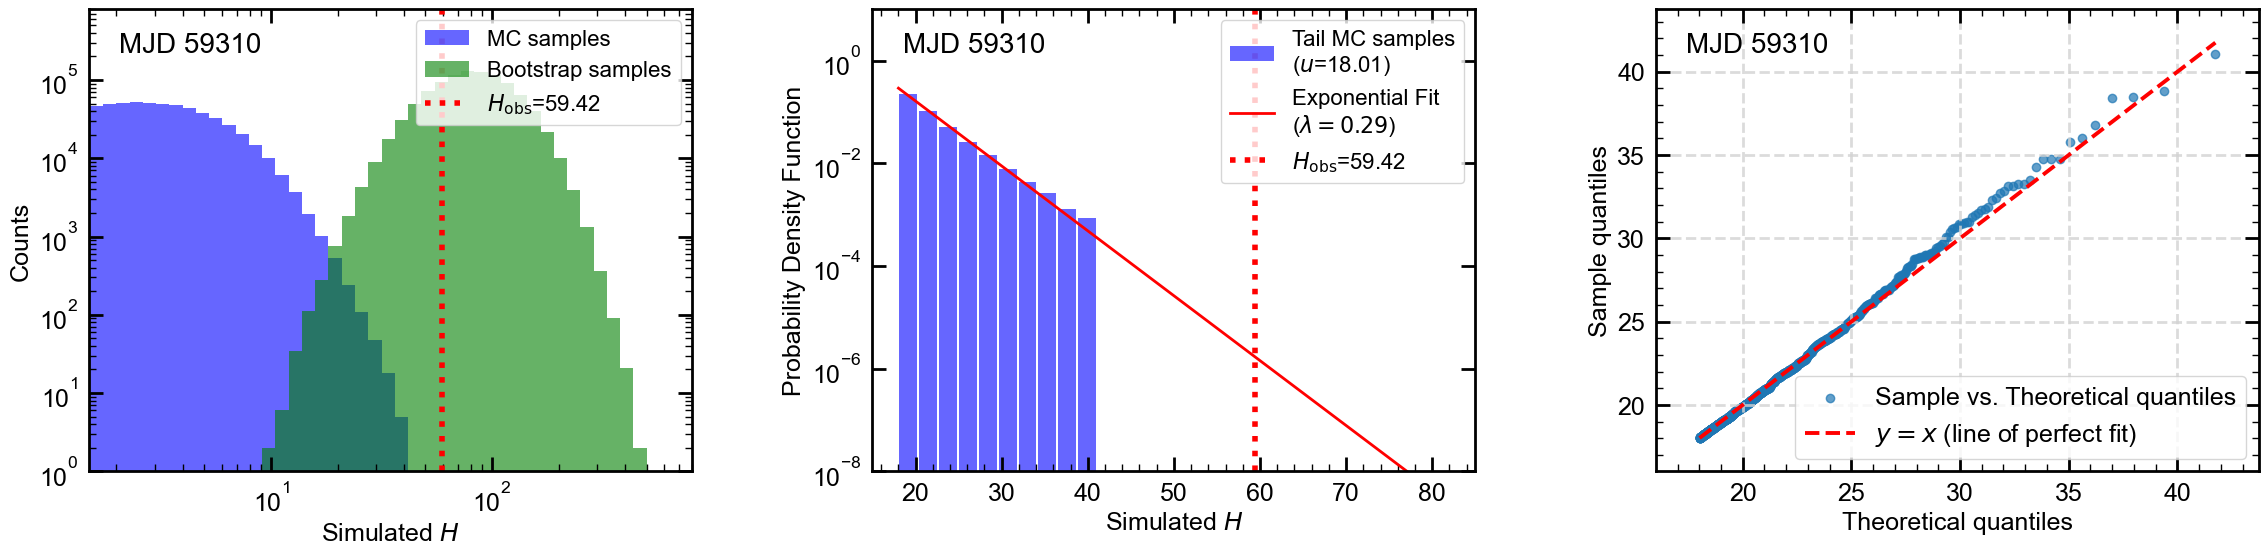

MJD 59310 H p-value: 5.836636e-09
Corresponding Gaussian significance: 5.7



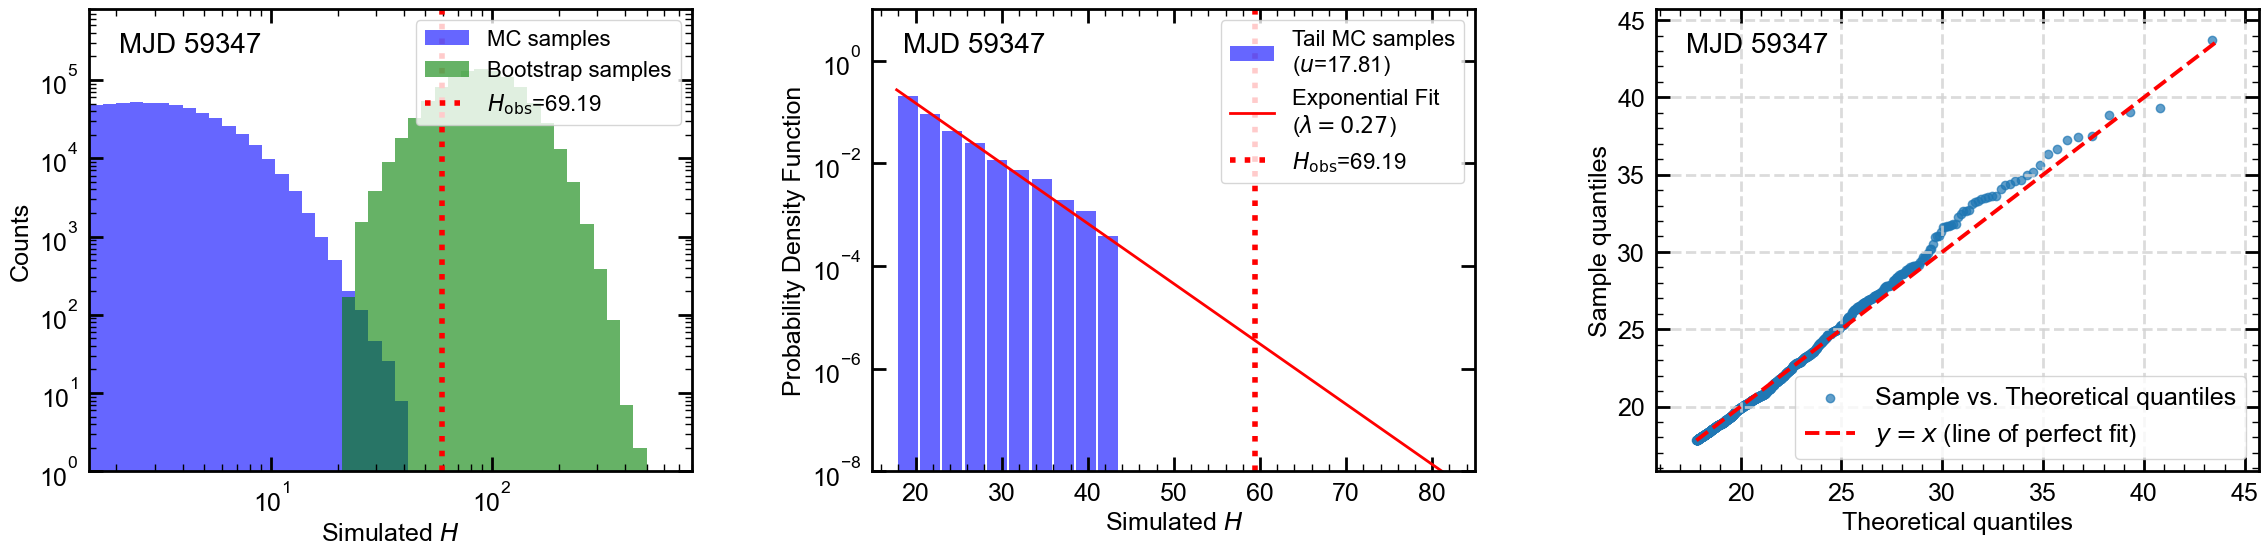

MJD 59347 H p-value: 9.350121e-10
Corresponding Gaussian significance: 6.0



In [19]:
# Plot Extended Data Figures 3 & 4
# These simulated samples are consistent with those in the paper. 
# For details on how they were generated, please refer to 'Generate MC and BS samples.ipynb'.
mc_chi2_59310=np.load('Data\\mc_chi2_59310_1e6.npy')
mc_chi2_59347=np.load('Data\\mc_chi2_59347_1e6.npy')
mc_H_59310=np.load('Data\\mc_H_59310_1e6.npy')
mc_H_59347=np.load('Data\\mc_H_59347_1e6.npy')
bs_chi2_59310=np.load('Data\\bs_chi2_59310_1e6.npy')
bs_chi2_59347=np.load('Data\\bs_chi2_59347_1e6.npy')
bs_H_59310=np.load('Data\\bs_H_59310_1e6.npy')
bs_H_59347=np.load('Data\\bs_H_59347_1e6.npy')

# MJD 59310 chi2
observed_chi2 = 4.3265383882644315
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 6))
# Histogram of simulated samples--ax1
counts, bin_edges, _ = ax1.hist(mc_chi2_59310, bins=np.logspace(-1, 1.5, 51), alpha=0.6, color='b', label='MC samples')
ax1.hist(bs_chi2_59310, bins=np.logspace(-1, 1.5, 51), alpha=0.6, color='g', label='Bootstrap samples')
ax1.axvline(observed_chi2, color='r', linestyle='dotted', lw=4, label='$\\chi^2_{\\mathrm{obs}}=%.2f$'%observed_chi2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.15, 30)
ax1.set_ylim(1, 8e5)
ax1.set_xlabel('Simulated $\\chi^2$')
ax1.set_ylabel('Counts')
ax1.legend(fontsize=12, loc='upper right')
ax1.text(0.05, 0.95, 'MJD 59310', transform=ax1.transAxes, fontsize=16, verticalalignment='top', horizontalalignment='left')
ax1.grid()

# Tail fiting--ax2
exceedances = np.sort(mc_chi2_59310)[-1000:][::-1]
u = np.min(exceedances)
excesses = exceedances - u
loc_fit, scale = stats.expon.fit(excesses, floc=0)
ax2.hist(exceedances, bins=np.linspace((min(exceedances)), (max(exceedances)), 11), density=True, rwidth=0.9, alpha=0.6, color='b', label='Tail MC samples\n($u$=%.2f)'%u)
x_range = np.linspace(min(exceedances), 6, 1000)
pdf = stats.expon.pdf(x_range, loc=u, scale=scale)
ax2.plot(x_range, pdf, 'r-', lw=2, label=f'Exponential Fit\n($\\lambda = {1/scale:.2f}$)')
ax2.axvline(observed_chi2, color='r', linestyle='dotted', lw=4, label='$\\chi^2_{\\mathrm{obs}}=%.2f$'%observed_chi2)
ax2.set_xlim(1.6, 5.4)
ax2.set_ylim(1e-11, 500)
ax2.set_xlabel('Simulated $\\chi^2$')
ax2.set_ylabel('Probability Density Function')
ax2.set_yscale('log')
ax2.text(0.05, 0.95, 'MJD 59310', transform=ax2.transAxes, fontsize=16, verticalalignment='top', horizontalalignment='left')
ax2.legend(fontsize=12, loc='upper right')
ax2.grid()

# Q-Q plotting--ax3
n_exceed = len(exceedances)
sample_quantiles = np.sort(exceedances)
prob_points = (np.arange(n_exceed) + 1) / (n_exceed + 1)
theoretical_quantiles = stats.expon.ppf(prob_points, loc=u, scale=scale)
ax3.scatter(theoretical_quantiles, sample_quantiles, alpha=0.7, label='Sample vs. Theoretical quantiles')
min_val = min(np.min(theoretical_quantiles), np.min(sample_quantiles))
max_val = max(np.max(theoretical_quantiles), np.max(sample_quantiles))
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y = x$ (line of perfect fit)')
ax3.set_xlim(min_val - 0.1, max_val + 0.1)
ax3.set_ylim(min_val - 0.1, max_val + 0.1)
ax3.set_xlabel('Theoretical quantiles')
ax3.set_ylabel('Sample quantiles')
ax3.text(0.05, 0.95, 'MJD 59310', transform=ax3.transAxes, fontsize=16, verticalalignment='top', horizontalalignment='left')
ax3.grid(True)
ax3.legend(loc='lower right')

plt.subplots_adjust(wspace=0.3)
plt.show()

prob_exceed_u = len(exceedances) / len(mc_chi2_59310)
prob_conditional = stats.expon.sf(observed_chi2 - u, loc=0, scale=scale)
final_p_value = prob_exceed_u * prob_conditional
print(f'MJD 59310 chi2 p-value: {final_p_value:.6e}')
print(f'Corresponding Gaussian significance: {stats.norm.ppf(1-final_p_value):.1f}\n')

# MJD 59347 chi2

# Histogram of simulated samples
observed_chi2 = 4.781083743842366
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 6))
# Histogram of simulated samples--ax1
counts, bin_edges, _ = ax1.hist(mc_chi2_59347, bins=np.logspace(-1, 1.5, 51), alpha=0.6, color='b', label='MC samples')
ax1.hist(bs_chi2_59347, bins=np.logspace(-1, 1.5, 51), alpha=0.6, color='g', label='Bootstrap samples')
ax1.axvline(observed_chi2, color='r', linestyle='dotted', lw=4, label='$\\chi^2_{\\mathrm{obs}}=%.2f$'%observed_chi2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.15, 30)
ax1.set_ylim(1, 8e5)
ax1.set_xlabel('Simulated $\\chi^2$')
ax1.set_ylabel('Counts')
ax1.legend(fontsize=12, loc='upper right')
ax1.text(0.05, 0.95, 'MJD 59347', transform=ax1.transAxes, fontsize=16, verticalalignment='top', horizontalalignment='left')
ax1.grid()

# Tail fiting--ax2
exceedances = np.sort(mc_chi2_59347)[-1000:][::-1]
u = np.min(exceedances)
excesses = exceedances - u
loc_fit, scale = stats.expon.fit(excesses, floc=0)
ax2.hist(exceedances, bins=np.linspace((min(exceedances)), (max(exceedances)), 11), density=True, rwidth=0.9, alpha=0.6, color='b', label='Tail MC samples\n($u$=%.2f)'%u)
x_range = np.linspace(min(exceedances), 6, 1000)
pdf = stats.expon.pdf(x_range, loc=u, scale=scale)
ax2.plot(x_range, pdf, 'r-', lw=2, label=f'Exponential Fit\n($\\lambda = {1/scale:.2f}$)')
ax2.axvline(observed_chi2, color='r', linestyle='dotted', lw=4, label='$\\chi^2_{\\mathrm{obs}}=%.2f$'%observed_chi2)
ax2.set_xlim(1.6, 5.4)
ax2.set_ylim(1e-11, 500)
ax2.set_xlabel('Simulated $\\chi^2$')
ax2.set_ylabel('Probability Density Function')
ax2.set_yscale('log')
ax2.text(0.05, 0.95, 'MJD 59347', transform=ax2.transAxes, fontsize=16, verticalalignment='top', horizontalalignment='left')
ax2.legend(fontsize=12, loc='upper right')
ax2.grid()

# Q-Q plotting--ax3
n_exceed = len(exceedances)
sample_quantiles = np.sort(exceedances)
prob_points = (np.arange(n_exceed) + 1) / (n_exceed + 1)
theoretical_quantiles = stats.expon.ppf(prob_points, loc=u, scale=scale)
ax3.scatter(theoretical_quantiles, sample_quantiles, alpha=0.7, label='Sample vs. Theoretical quantiles')
min_val = min(np.min(theoretical_quantiles), np.min(sample_quantiles))
max_val = max(np.max(theoretical_quantiles), np.max(sample_quantiles))
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y = x$ (line of perfect fit)')
ax3.set_xlim(min_val - 0.1, max_val + 0.1)
ax3.set_ylim(min_val - 0.1, max_val + 0.1)
ax3.set_xlabel('Theoretical quantiles')
ax3.set_ylabel('Sample quantiles')
ax3.text(0.05, 0.95, 'MJD 59347', transform=ax3.transAxes, fontsize=16, verticalalignment='top', horizontalalignment='left')
ax3.grid(True)
ax3.legend(loc='lower right')

plt.subplots_adjust(wspace=0.3)
plt.show()

prob_exceed_u = len(exceedances) / len(mc_chi2_59347)
prob_conditional = stats.expon.sf(observed_chi2 - u, loc=0, scale=scale)
final_p_value = prob_exceed_u * prob_conditional
print(f'MJD 59347 chi2 p-value: {final_p_value:.6e}')
print(f'Corresponding Gaussian significance: {stats.norm.ppf(1-final_p_value):.1f}\n')

# MJD 59310 H
observed_H = 59.42
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 6))
# Histogram of simulated samples--ax1
counts, bin_edges, _ = ax1.hist(mc_H_59310, bins=np.logspace(0, 3, 51), alpha=0.6, color='b', label='MC samples')
ax1.hist(bs_H_59310, bins=np.logspace(0, 3, 51), alpha=0.6, color='g', label='Bootstrap samples')
ax1.axvline(59.42, color='r', linestyle='dotted', lw=4, label='$H_{\\mathrm{obs}}$=%.2f'%observed_H)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1.5, 800)
ax1.set_ylim(1, 8e5)
ax1.set_xlabel('Simulated $H$')
ax1.set_ylabel('Counts')
ax1.legend(fontsize=16, loc='upper right')
ax1.text(0.05, 0.95, 'MJD 59310', transform=ax1.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='left')
ax1.grid()

# Tail fitting--ax2
exceedances = np.sort(mc_H_59310)[-1000:][::-1]
u = np.min(exceedances)
excesses = exceedances - u
loc_fit, scale = stats.expon.fit(excesses, floc=0)
ax2.hist(exceedances, bins=np.linspace(min(exceedances), max(exceedances), 11), density=True, rwidth=0.9, alpha=0.6, color='b', label='Tail MC samples\n($u$=%.2f)'%u)
x_range = np.linspace(min(exceedances), 90, 1000)
pdf = stats.expon.pdf(x_range, loc=u, scale=scale)
ax2.plot(x_range, pdf, 'r-', lw=2, label=f'Exponential Fit \n($\\lambda = {1/scale:.2f}$)')
ax2.axvline(59.42, color='r', linestyle='dotted', lw=4, label='$H_{\\mathrm{obs}}$=%.2f'%observed_H)
ax2.set_xlim(15, 85)
ax2.set_ylim(1e-8, 10)
ax2.set_xlabel('Simulated $H$')
ax2.set_ylabel('Probability Density Function')
ax2.set_yscale('log')
ax2.text(0.05, 0.95, 'MJD 59310', transform=ax2.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='left')
ax2.legend(fontsize=16, loc='upper right')
ax2.grid()

# Q-Q plotting--ax3
n_exceed = len(exceedances)
sample_quantiles = np.sort(exceedances)
prob_points = (np.arange(n_exceed) + 1) / (n_exceed + 1)
theoretical_quantiles = stats.expon.ppf(prob_points, loc=u, scale=scale)
ax3.scatter(theoretical_quantiles, sample_quantiles, alpha=0.7, label='Sample vs. Theoretical quantiles')
min_val = min(np.min(theoretical_quantiles), np.min(sample_quantiles))
max_val = max(np.max(theoretical_quantiles), np.max(sample_quantiles))
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y = x$ (line of perfect fit)')
ax3.set_xlim(min_val - 2, max_val + 2)
ax3.set_ylim(min_val - 2, max_val + 2)
ax3.set_xlabel('Theoretical quantiles')
ax3.set_ylabel('Sample quantiles')
ax3.text(0.05, 0.95, 'MJD 59310', transform=ax3.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='left')
ax3.grid(True)
ax3.legend(loc='lower right')

plt.subplots_adjust(wspace=0.3)
plt.show()

prob_exceed_u = len(exceedances) / len(mc_H_59310)
prob_conditional = stats.expon.sf(observed_H - u, loc=0, scale=scale)
final_p_value = prob_exceed_u * prob_conditional
print(f'MJD 59310 H p-value: {final_p_value:.6e}')
print(f'Corresponding Gaussian significance: {stats.norm.ppf(1-final_p_value):.1f}\n')

# MJD 59347 H
observed_H = 69.19
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 6))
# Histogram of simulated samples--ax1
counts, bin_edges, _ = ax1.hist(mc_H_59347, bins=np.logspace(0, 3, 51), alpha=0.6, color='b', label='MC samples')
ax1.hist(bs_H_59347, bins=np.logspace(0, 3, 51), alpha=0.6, color='g', label='Bootstrap samples')
ax1.axvline(59.42, color='r', linestyle='dotted', lw=4, label='$H_{\\mathrm{obs}}$=%.2f'%observed_H)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1.5, 800)
ax1.set_ylim(1, 8e5)
ax1.set_xlabel('Simulated $H$')
ax1.set_ylabel('Counts')
ax1.legend(fontsize=16, loc='upper right')
ax1.text(0.05, 0.95, 'MJD 59347', transform=ax1.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='left')
ax1.grid()

# Tail fitting--ax2
exceedances = np.sort(mc_H_59347)[-1000:][::-1]
u = np.min(exceedances)
excesses = exceedances - u
loc_fit, scale = stats.expon.fit(excesses, floc=0)
ax2.hist(exceedances, bins=np.linspace(min(exceedances), max(exceedances), 11), density=True, rwidth=0.9, alpha=0.6, color='b', label='Tail MC samples\n($u$=%.2f)'%u)
x_range = np.linspace(min(exceedances), 90, 1000)
pdf = stats.expon.pdf(x_range, loc=u, scale=scale)
ax2.plot(x_range, pdf, 'r-', lw=2, label=f'Exponential Fit \n($\\lambda = {1/scale:.2f}$)')
ax2.axvline(59.42, color='r', linestyle='dotted', lw=4, label='$H_{\\mathrm{obs}}$=%.2f'%observed_H)
ax2.set_xlim(15, 85)
ax2.set_ylim(1e-8, 10)
ax2.set_xlabel('Simulated $H$')
ax2.set_ylabel('Probability Density Function')
ax2.set_yscale('log')
ax2.text(0.05, 0.95, 'MJD 59347', transform=ax2.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='left')
ax2.legend(fontsize=16, loc='upper right')
ax2.grid()

# Q-Q plotting--ax3
n_exceed = len(exceedances)
sample_quantiles = np.sort(exceedances)
prob_points = (np.arange(n_exceed) + 1) / (n_exceed + 1)
theoretical_quantiles = stats.expon.ppf(prob_points, loc=u, scale=scale)
ax3.scatter(theoretical_quantiles, sample_quantiles, alpha=0.7, label='Sample vs. Theoretical quantiles')
min_val = min(np.min(theoretical_quantiles), np.min(sample_quantiles))
max_val = max(np.max(theoretical_quantiles), np.max(sample_quantiles))
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y = x$ (line of perfect fit)')
ax3.set_xlim(min_val - 2, max_val + 2)
ax3.set_ylim(min_val - 2, max_val + 2)
ax3.set_xlabel('Theoretical quantiles')
ax3.set_ylabel('Sample quantiles')
ax3.text(0.05, 0.95, 'MJD 59347', transform=ax3.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='left')
ax3.grid(True)
ax3.legend(loc='lower right')

plt.subplots_adjust(wspace=0.3)
plt.show()

prob_exceed_u = len(exceedances) / len(mc_H_59347)
prob_conditional = stats.expon.sf(observed_H - u, loc=0, scale=scale)
final_p_value = prob_exceed_u * prob_conditional
print(f'MJD 59347 H p-value: {final_p_value:.6e}')
print(f'Corresponding Gaussian significance: {stats.norm.ppf(1-final_p_value):.1f}\n')


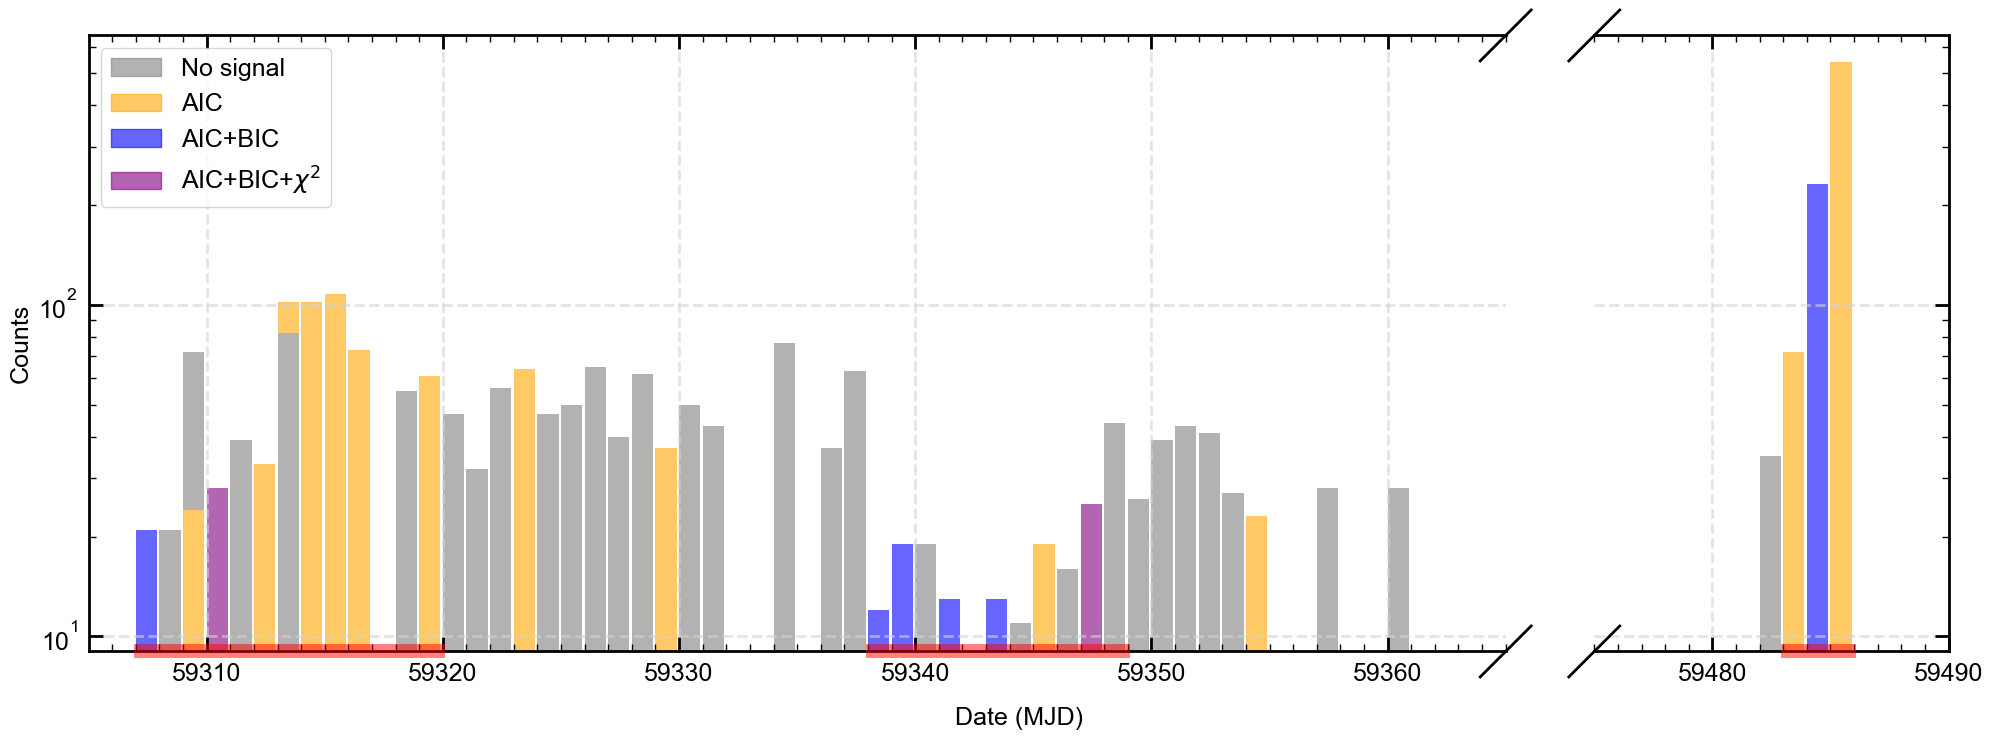

In [15]:
# Plot Extended Data Figure 5
summary_df=pd.read_csv('Data\\Extended Data Figure 5.csv')
fig = plt.figure(figsize=(24, 8))
bax = brokenaxes(xlims=((59305, 59365), (59475, 59490)),
                 wspace=0.1, despine=False, diag_color='k')
bax.bar(
    summary_df['MJD'],
    summary_df['FAST_count'],
    color=summary_df['FAST_color'],
    width=0.9,
    alpha=0.6,
    align='edge',
)

bax.bar(
    summary_df['MJD'],
    summary_df['Effelsberg_count'],
    color=summary_df['Effelsberg_color'],
    width=0.9,
    alpha=0.6,
    align='edge',
    bottom=summary_df['FAST_count'], 
)

bax.bar(
    summary_df['MJD'],
    summary_df['uGMRT_count'],
    color=summary_df['uGMRT_color'],
    width=0.9,
    alpha=0.6,
    align='edge',
    bottom=summary_df['FAST_count'], 
)

max_height = summary_df['FAST_count'].max()
y_max = max_height * 1.2
bax.set_ylim(bottom=9, top=y_max)
bax.set_yscale('log')

bax.set_xlabel('Date (MJD)', labelpad=40)
bax.set_ylabel('Counts', labelpad=40)

legend_patches = [
    mpatches.Patch(color='grey', alpha=0.6, label='No signal'),
    mpatches.Patch(color='orange', alpha=0.6, label='AIC'),
    mpatches.Patch(color='blue', alpha=0.6, label='AIC+BIC'),
    mpatches.Patch(color='purple', alpha=0.6, label='AIC+BIC+$\\chi^2$'),
]
plt.legend(handles=legend_patches, loc='upper left', fontsize=18)

for ax in bax.axs:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.FixedLocator([10, 100, 1000]))

bax.axs[1].xaxis.set_ticks_position('both')
bax.axs[1].yaxis.set_ticks_position('right')
bax.axs[1].yaxis.set_tick_params(labelright=False)
bax.axs[0].xaxis.set_ticks_position('both')
bax.axs[0].yaxis.set_ticks_position('left')

for ax in bax.axs:
    ax.grid(True)
for ax in bax.axs:
    ax.xaxis.set_minor_locator(MultipleLocator(1))

line1 = plt.Line2D([59307 + 0.2, 59320 - 0.2], [9, 9], color='r', alpha=0.5, linewidth=10, transform=bax.axs[0].transData, clip_on=False)
fig.add_artist(line1)
line3 = plt.Line2D([59338 + 0.2, 59349 - 0.2], [9, 9], color='r', alpha=0.5, linewidth=10, transform=bax.axs[0].transData, clip_on=False)
fig.add_artist(line3)
line4 = plt.Line2D([59483 + 0.2, 59486 - 0.2], [9, 9], color='r', alpha=0.5, linewidth=10, transform=bax.axs[1].transData, clip_on=False)
fig.add_artist(line4)
plt.show()

In [39]:
# Plot Extended Data Figures 8
b_ss_fast1=burstverify_anyday(b_fast1,nummin=1,dnum=1,sep=0)
b_ss_fast2=burstverify_anyday(b_fast2,nummin=1,dnum=1,sep=0)
b_ss_ugmrt=burstverify_anyday(b_ugmrt,nummin=1,dnum=1,sep=0)
b_ss_effelseberg=burstverify_anyday(b_effelsberg,nummin=1,dnum=1,sep=0)

# Equation 7
def calculate_phase(t, period, pdot):
    phase = np.fmod((1 / pdot) * (np.log(period + pdot * t) - np.log(period)), 1.0)
    phase = np.where(phase < 0.0, phase + 1.0, phase)
    return phase

p_0 = 1.706017 # MJD 59310 period 
t_0 = np.mean(b_ss[1][3]['t_s']) # MJD 59310 mean TOA
p_1 = 1.707972 # MJD 59347 period
t_1 = np.mean(b_ss[1][35]['t_s']) # MJD 59347 mean TOA
pdot = (p_1-p_0)/(t_1-t_0)

# Unimodal negative log likelihood
def nll_unimodal(params, data):
    mu, kappa = params
    mu_rad = mu * 2 * np.pi
    return -np.sum(stats.vonmises.logpdf(data * 2 * np.pi, kappa, loc=mu_rad))

# Bimodal negative log likelihood
def nll_bimodal(params, data):
    mu1, kappa1,kappa2,fr1 = params
    mu1_rad = mu1 * 2 * np.pi
    mu2_rad = (mu1 + 0.5) * 2 * np.pi
    log_likelihood = np.log(fr1 * stats.vonmises.pdf(data * 2 * np.pi, kappa1, loc=mu1_rad) + \
                            (1-fr1) * stats.vonmises.pdf(data * 2 * np.pi, kappa2, loc=mu2_rad))
    return -np.sum(log_likelihood)
    
def calculate_aic(k, nll):
    return 2 * k + 2 * nll

def calculate_bic(k, nll, n):
    return k * np.log(n) + 2 * nll

# Wrap fitting and plotting in a function
def fit_plot(i,p_0,t_0,pdot,ds,pf):
    mpl.use('Agg')
    plt.rcParams.update(rc_dict)
    p_1=p_0+pdot*(np.mean(b_sss['t_s'])-t_0)
    pdot_i=pdot+i*1e-13
    p_i=p_0+pdot_i*(np.mean(b_sss['t_s'])-t_0)
    deviation=(p_i-p_1)/p_1
    folded_phases = calculate_phase(b_sss['t_s']-t_0, p_0, pdot_i)
    data_to_analyze = folded_phases
    n_samples = len(data_to_analyze)
    
    # Fit unimodal 
    fit_uni = differential_evolution(nll_unimodal, args=(data_to_analyze,), bounds=[(0, 1), (0.1, 100)])
    nll_uni_min = fit_uni.fun
    params_uni = fit_uni.x

    # Fit bimodal 
    fit_bi = differential_evolution(nll_bimodal, args=(data_to_analyze,), bounds=[(0, 1), (1, 10), (1,10), (0.,1)])
    nll_bi_min = fit_bi.fun
    params_bi = fit_bi.x
    
    results = {}
    # Uniform (k=0)
    nll_uniform = -np.sum(np.log(1 / (2 * np.pi)) * np.ones_like(data_to_analyze))
    results['Uniform'] = {
        'k': 0, 'nll': nll_uniform, 'params': 'N/A',
        'aic': calculate_aic(0, nll_uniform),
        'bic': calculate_bic(0, nll_uniform, n_samples)
    }
    # Unimodal (k=2)
    results['Unimodal'] = {
        'k': 2, 'nll': nll_uni_min, 'params': params_uni,
        'aic': calculate_aic(2, nll_uni_min),
        'bic': calculate_bic(2, nll_uni_min, n_samples)
    }
    # Bimodal (k=2)
    results['Bimodal'] = {
        'k': 4, 'nll': nll_bi_min, 'params': params_bi,
        'aic': calculate_aic(4, nll_bi_min),
        'bic': calculate_bic(4, nll_bi_min, n_samples)
    }
    
    # Find best model
    best_aic_model = min(results.items(), key=lambda item: item[1]['aic'])
    best_bic_model = min(results.items(), key=lambda item: item[1]['bic'])
    best_aic_name = best_aic_model[0]
    best_bic_name = best_bic_model[0]
    labels = {}
    for name, res in results.items():
        is_min_aic = '*' if name == best_aic_name  else ''
        is_min_bic = '*' if name == best_bic_name else ''
        model_part = name.ljust(9)
        aic_part = f"{is_min_aic}AIC={res['aic']:.1f}"
        bic_part = f"{is_min_bic}BIC={res['bic']:.1f}"
        labels[name] = f'{model_part}({aic_part}, {bic_part})'
        
    fig, ax = plt.subplots(figsize=(8, 6))
    hist_data, hist_bins, _ = ax.hist(data_to_analyze, bins=np.linspace(0,1,21), density=True, alpha=0.6, color='royalblue')
    ax.hist(data_to_analyze+1, bins=np.linspace(1,2,21), density=True, alpha=0.6, color='royalblue')
    x_axis = np.linspace(0, 1, 500)
    # Plot uniform 
    ax.plot([0, 2], [1, 1], lw=2, ls=':', color='grey', label=labels.get('Uniform', 'Uniform'))
    # Plot fitted curve of unimodal
    pdf_uni_fit = stats.vonmises.pdf(x_axis * 2 * np.pi, params_uni[1], loc=params_uni[0] * 2 * np.pi)
    ax.plot(x_axis, pdf_uni_fit*2*np.pi, lw=2, ls='--', color='coral', label=labels.get('Unimodal', 'Unimodal'))
    ax.plot(x_axis+1, pdf_uni_fit*2*np.pi, lw=2, ls='--', color='coral')
    # Plot fitted curve of bimodal
    pdf_bi_fit = params_bi[3] * stats.vonmises.pdf(x_axis * 2 * np.pi, params_bi[1], loc=params_bi[0] * 2 * np.pi) + \
                 (1-params_bi[3]) * stats.vonmises.pdf(x_axis * 2 * np.pi, params_bi[2], loc=(params_bi[0] + 0.5) * 2 * np.pi)
    ax.plot(x_axis, pdf_bi_fit*2*np.pi, lw=2, ls='-.', color='green', label=labels.get('Bimodal', 'Bimodal'))
    ax.plot(x_axis+1, pdf_bi_fit*2*np.pi, lw=2, ls='-.', color='green')
    ax.set_xlabel('Phase')
    ax.set_ylabel('Density')
    ax.set_ylim(0, max(hist_data) * 1.28) 
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(alpha=0.3)
    ax.legend(loc='upper right', fontsize=15, frameon=False)
    if max(b_sss['t'])-min(b_sss['t']) < 1 :
        ax.text(0.03, 0.962, ds, transform=ax.transAxes, fontsize=15,
                verticalalignment='top', horizontalalignment='left')
        ax.text(0.03, 0.897, 'MJD %i' % ((np.floor(min(b_sss['t'])))), transform=ax.transAxes, fontsize=15,
                verticalalignment='top', horizontalalignment='left')
        ax.text(0.03, 0.832, '%i bursts' % (len(b_sss['t'])), transform=ax.transAxes, fontsize=15,
                verticalalignment='top', horizontalalignment='left')
        if np.floor(min(b_sss['t'])) == 59310 or np.floor(min(b_sss['t'])) == 59347:
            line_color = 'purple'
        elif best_aic_name == 'Uniform' and best_bic_name == 'Uniform':
            line_color = 'grey'
        elif best_bic_name == 'Uniform': 
            line_color = 'orange'
        else: 
            line_color = 'blue'
        bbox = ax.get_position()
        line = plt.Line2D([bbox.x0, bbox.x1], [bbox.y1 + 0.02, bbox.y1 + 0.02],
                      color=line_color, alpha=0.6,
                      linewidth=10,  
                      transform=fig.transFigure, 
                      clip_on=False)
        fig.add_artist(line)    
        output_file = Path(pf+'\\MJD %i_%i' % ((np.floor(min(b_sss['t']))),i))
    else:
        ax.text(0.03, 0.962, ds, transform=ax.transAxes, fontsize=15,
                verticalalignment='top', horizontalalignment='left')
        ax.text(0.03, 0.897, 'MJD %i-%i' % ((np.floor(min(b_sss['t']))),(np.floor(max(b_sss['t'])))), transform=ax.transAxes, fontsize=15,
                verticalalignment='top', horizontalalignment='left')
        ax.text(0.03, 0.832, '%i bursts' % (len(b_sss['t'])), transform=ax.transAxes, fontsize=15,
                verticalalignment='top', horizontalalignment='left')
        output_file = Path(pf+'\\MJD %i-%i_%i' % ((np.floor(min(b_sss['t']))),(np.floor(max(b_sss['t']))),i))
    output_file.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_file.with_suffix('.svg')) 
    plt.close(fig)
    return results


# Save results to "Folded Phases" folder
pf='Folded Phases\\FAST#1'
for k in tqdm.tqdm(range(len(b_ss_fast1[1]))):
    day=k
    b_sss = b_ss_fast1[1][k]
    _=Parallel(n_jobs=-1)(delayed(fit_plot)(i,p_0,t_0,pdot,'FAST #1',pf) for i in range(0, 1)) # i = 0 for nominal pdot
    
pf='Folded Phases\\FAST#2'
for k in tqdm.tqdm(range(len(b_ss_fast2[1]))):
    day=k
    b_sss = b_ss_fast2[1][k]
    _=Parallel(n_jobs=-1)(delayed(fit_plot)(i,p_0,t_0,pdot,'FAST #2',pf) for i in range(0, 1)) # i = 0 for nominal pdot

pf='Folded Phases\\uGMRT'
for k in tqdm.tqdm(range(len(b_ss_ugmrt[1]))):
    day=k
    b_sss = b_ss_ugmrt[1][k]
    _=Parallel(n_jobs=-1)(delayed(fit_plot)(i,p_0,t_0,pdot,'uGMRT',pf) for i in range(0, 1)) # i = 0 for nominal pdot

pf='Folded Phases\\Effelsberg'
for k in tqdm.tqdm(range(len(b_ss_effelseberg[1]))):
    day=k
    b_sss = b_ss_effelseberg[1][k]
    _=Parallel(n_jobs=-1)(delayed(fit_plot)(i,p_0,t_0,pdot,'Effelsberg',pf) for i in range(0, 1)) # i = 0 for nominal pdot

# Plot Extended Data Figures 7
pf='Folded Phases\\Multi-day Blocks'
b_sss = pd.concat(b_ss_fast1[1][0:12]) # Block 1: MJD 59307 -- 59319 (FAST-detected bursts)
_=Parallel(n_jobs=-1)(delayed(fit_plot)(i,p_0,t_0,pdot,'FAST #1',pf) for i in range(0, 1)) # i = 0 for nominal pdot
b_sss = pd.concat(b_ss_fast1[1][27:37]) # Block 2: MJD 59307 -- 59319
_=Parallel(n_jobs=-1)(delayed(fit_plot)(i,p_0,t_0,pdot,'FAST #1',pf) for i in range(0, 1)) # i = 0 for nominal pdot
b_sss = pd.concat(b_ss_fast2[1][1:4]) # Block 3: MJD 59483 -- 59485
_=Parallel(n_jobs=-1)(delayed(fit_plot)(i,p_0,t_0,pdot,'FAST #2',pf) for i in range(0, 1)) # i = 0 for nominal pdot

print('Please check the results in the "Folded Phases" folder.')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


Please check the results in the "Folded Phases" folder.


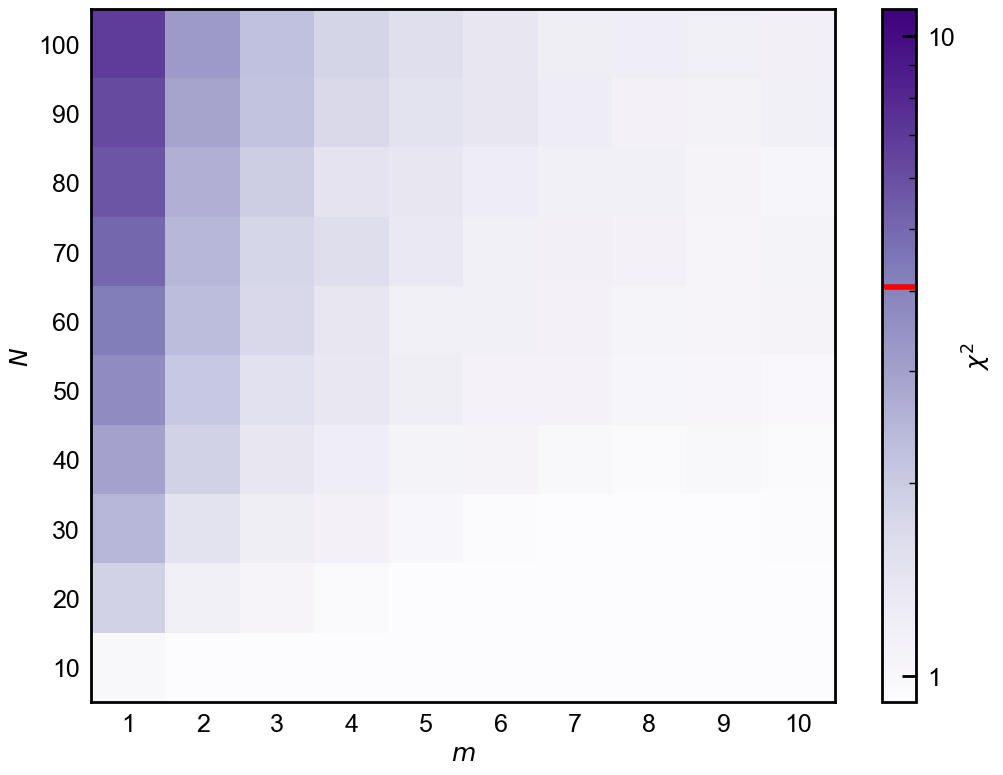

In [33]:
# Plot Extended Data Figure 9
# These simulated samples are consistent with those in the paper. 
# For details on how they were generated, please refer to 'Generate N bursts from m emission sites.ipynb'.
chi2_matrix=np.load('Data\\chi2_matrix.npy')

n_values = [100,90,80,70,60,50,40,30,20,10]
m_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
fig, ax = plt.subplots(figsize=(12, 9))
cax=ax.imshow(chi2_matrix, cmap='Purples', aspect='auto', norm=LogNorm(0.91,11))
cbar=fig.colorbar(cax,format=LogFormatter(10, labelOnlyBase=False))
plt.xlabel('$m$')
plt.ylabel('$N$')
plt.yticks([0,1,2,3,4,5,6,7,8,9],n_values)
plt.xticks([0,1,2,3,4,5,6,7,8,9],m_values)
plt.minorticks_off()
plt.tick_params(top=False,bottom=False,left=False,right=False)
cbar.set_label('$\\chi^2$')
nbin=30
p_value_1 = (1 - stats.norm.cdf(7))
thpf_1= np.mean(stats.chi2.isf(p_value_1, nbin-1)/(nbin-1))
cbar.ax.hlines(thpf_1, *cbar.ax.get_xlim(), color='red', linewidth=4)
plt.grid(False)